# Warren-Style Ratio Diagnostics: Iron Interference Analysis

This notebook performs Warren-style ratio diagnostics to quantify iron-associated absorption in HIPS and Aethalometer measurements.

## Analysis Approach:
- Plot **F_abs/EC vs Fe/EC** for HIPS
- Plot **B_abs/EC vs Fe/EC** for Aethalometer  
- Report intercept (A), slope (B), and R² using both Deming and OLS regression

The intercept represents the absorption per unit EC when Fe/EC = 0 (pure BC absorption).
The slope represents the iron-specific absorption contribution.

## 1. Setup and Imports

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, odr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Import the modular data loader
import sys
sys.path.append('..')
from src.data.loaders import AethalometerFilterMatcher

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Load and Prepare Data

In [16]:
# Define wavelength-specific attenuation cross-sections (σATN) for Babs calculation
SIGMA_ATN = {
    'IR': 10.120,      # 880 nm
    'Red': 14.091,     # 625 nm  
    'Green': 17.028,   # 528 nm
    'Blue': 19.070,    # 470 nm
    'UV': 24.069       # 375 nm
}

print("📊 Wavelength-specific attenuation cross-sections (σATN):")
for wavelength, sigma in SIGMA_ATN.items():
    print(f"   {wavelength}: {sigma} m²/g")

📊 Wavelength-specific attenuation cross-sections (σATN):
   IR: 10.12 m²/g
   Red: 14.091 m²/g
   Green: 17.028 m²/g
   Blue: 19.07 m²/g
   UV: 24.069 m²/g


In [17]:
# Load and match data
aethalometer_path = "../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl"
filter_db_path = "../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl"

print("🔗 Loading and matching ETAD data...")

# Create matcher and load data
matcher = AethalometerFilterMatcher(aethalometer_path, filter_db_path)

# Match ETAD data with all necessary parameters
matched_data = matcher.match_site_data(
    'ETAD',
    filter_parameters=['EC_ftir', 'HIPS_Fabs', 'ChemSpec_Iron_PM2.5'],
    aethalometer_columns=[
        'IR BCc smoothed', 'Red BCc smoothed', 
        'Green BCc smoothed', 'Blue BCc smoothed', 'UV BCc smoothed'
    ]
)

print(f"\n✅ Data matching complete! Shape: {matched_data.shape}")
print(f"📅 Date range: {matched_data['match_date'].min()} to {matched_data['match_date'].max()}")

🔗 Loading and matching ETAD data...
Loading complete filter dataset from ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl...
Dataset loaded successfully!
   Total measurements: 44,493
   Unique filters: 1,603
   Sites: CHTS, ETAD, INDH, USPA
   Date range: 2013-06-28 to 2024-12-08
   Data sources: ChemSpec, FTIR, HIPS
✅ Filter database loaded from: ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl
🔗 Matching aethalometer and filter data for ETAD...
✅ Aethalometer data loaded from: ../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl
   Dataset shape: (1047, 320)
   Date range: 2022-04-13 09:00:00+03:00 to 2025-06-25 09:00:00+03:00
   No 'Site' column found - assuming single site data
📍 No 'Site' column - assuming all data is for ETAD
📂 Extracting ETAD filter measurements...
   ✅ EC_ftir: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ HIPS_Fabs: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ Iron_ChemSpec: 188 measurements
      Date range: 20

In [18]:
# Convert BCc from ng/m³ to μg/m³ and calculate Babs
print("🔄 Converting BCc units and calculating Babs...\n")

# Convert all BCc columns from ng/m³ to μg/m³
bc_columns = [col for col in matched_data.columns if 'BCc smoothed' in col]
for col in bc_columns:
    if col in matched_data.columns:
        matched_data[col] = matched_data[col] / 1000.0  # ng/m³ → μg/m³

# Calculate Babs for each wavelength
for wavelength, sigma in SIGMA_ATN.items():
    bc_col = f'{wavelength} BCc smoothed'
    babs_col = f'{wavelength} Babs'
    
    if bc_col in matched_data.columns:
        # Babs = BCc (μg/m³) × σATN (m²/g)
        matched_data[babs_col] = matched_data[bc_col] * sigma
        
        # Show statistics
        if matched_data[babs_col].notna().sum() > 0:
            mean_bc = matched_data[bc_col].mean()
            mean_babs = matched_data[babs_col].mean()
            print(f"   {wavelength}: BCc = {mean_bc:.3f} μg/m³, Babs = {mean_babs:.1f} Mm⁻¹")

print("\n✅ Babs calculated for all wavelengths")

🔄 Converting BCc units and calculating Babs...

   IR: BCc = 7.789 μg/m³, Babs = 78.8 Mm⁻¹
   Red: BCc = 7.740 μg/m³, Babs = 109.1 Mm⁻¹
   Green: BCc = 4.244 μg/m³, Babs = 72.3 Mm⁻¹
   Blue: BCc = 7.875 μg/m³, Babs = 150.2 Mm⁻¹
   UV: BCc = 22.219 μg/m³, Babs = 534.8 Mm⁻¹

✅ Babs calculated for all wavelengths


## 3. Define Regression Functions

In [19]:
def deming_regression(x, y, delta=1.0):
    """
    Perform Deming regression (errors in both variables).
    
    Parameters:
    - x, y: data arrays
    - delta: ratio of variance of errors in y to variance of errors in x
    
    Returns:
    - slope, intercept
    """
    n = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Calculate variances and covariance
    s_xx = np.sum((x - x_mean)**2) / (n - 1)
    s_yy = np.sum((y - y_mean)**2) / (n - 1)
    s_xy = np.sum((x - x_mean) * (y - y_mean)) / (n - 1)
    
    # Deming regression formula
    lambda_val = 0.5 * ((s_yy - delta * s_xx) + np.sqrt((s_yy - delta * s_xx)**2 + 4 * delta * s_xy**2))
    
    if s_xy == 0:
        slope = 0
    else:
        slope = lambda_val / s_xy
    
    intercept = y_mean - slope * x_mean
    
    return slope, intercept

def calculate_r_squared(x, y, y_pred):
    """
    Calculate R² for regression.
    """
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    
    if ss_tot == 0:
        return 0
    
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

print("✅ Regression functions defined")

✅ Regression functions defined


## 4. HIPS Warren-Style Analysis (F_abs/EC vs Fe/EC)

In [20]:
# Prepare HIPS data
print("📊 HIPS Warren-Style Ratio Analysis")
print("=" * 60)

# Filter for valid data
hips_mask = matched_data[['HIPS_Fabs', 'EC_ftir', 'Iron_ChemSpec']].notna().all(axis=1)
hips_valid = matched_data[hips_mask].copy()

if len(hips_valid) > 3:
    # Calculate ratios
    hips_valid['Fabs_EC_ratio'] = hips_valid['HIPS_Fabs'] / hips_valid['EC_ftir']
    hips_valid['Fe_EC_ratio'] = (hips_valid['Iron_ChemSpec'] / 1000.0) / hips_valid['EC_ftir']  # Convert Fe from ng/m³ to μg/m³
    
    # Remove any infinite or NaN values
    ratio_mask = np.isfinite(hips_valid['Fabs_EC_ratio']) & np.isfinite(hips_valid['Fe_EC_ratio'])
    hips_clean = hips_valid[ratio_mask]
    
    print(f"Valid data points: {len(hips_clean)}")
    print(f"\nData ranges:")
    print(f"  F_abs/EC: {hips_clean['Fabs_EC_ratio'].min():.2f} - {hips_clean['Fabs_EC_ratio'].max():.2f} Mm⁻¹/(μg/m³)")
    print(f"  Fe/EC: {hips_clean['Fe_EC_ratio'].min():.4f} - {hips_clean['Fe_EC_ratio'].max():.4f} (unitless)")
    
    # Store for later use
    hips_x = hips_clean['Fe_EC_ratio'].values
    hips_y = hips_clean['Fabs_EC_ratio'].values
else:
    print("❌ Insufficient HIPS data for analysis")
    hips_x = None
    hips_y = None

📊 HIPS Warren-Style Ratio Analysis
Valid data points: 174

Data ranges:
  F_abs/EC: 5.87 - 55.41 Mm⁻¹/(μg/m³)
  Fe/EC: 0.0094 - 0.3412 (unitless)


In [21]:
# Perform HIPS regressions
if hips_x is not None and len(hips_x) > 3:
    print("\n🔬 HIPS Regression Results:")
    print("=" * 40)
    
    # OLS Regression
    ols_model = LinearRegression()
    ols_model.fit(hips_x.reshape(-1, 1), hips_y)
    ols_slope = ols_model.coef_[0]
    ols_intercept = ols_model.intercept_
    ols_pred = ols_model.predict(hips_x.reshape(-1, 1))
    ols_r2 = calculate_r_squared(hips_x, hips_y, ols_pred)
    
    print("\n📈 OLS Regression:")
    print(f"  Intercept A = {ols_intercept:.3f} Mm⁻¹/(μg/m³)")
    print(f"  Slope B = {ols_slope:.3f} Mm⁻¹/(μg/m³)")
    print(f"  R² = {ols_r2:.4f}")
    
    # Deming Regression
    deming_slope, deming_intercept = deming_regression(hips_x, hips_y, delta=1.0)
    deming_pred = deming_intercept + deming_slope * hips_x
    deming_r2 = calculate_r_squared(hips_x, hips_y, deming_pred)
    
    print("\n📊 Deming Regression:")
    print(f"  Intercept A = {deming_intercept:.3f} Mm⁻¹/(μg/m³)")
    print(f"  Slope B = {deming_slope:.3f} Mm⁻¹/(μg/m³)")
    print(f"  R² = {deming_r2:.4f}")
    
    # Store results
    hips_results = {
        'OLS': {'intercept': ols_intercept, 'slope': ols_slope, 'r2': ols_r2},
        'Deming': {'intercept': deming_intercept, 'slope': deming_slope, 'r2': deming_r2}
    }
    
    print("\n💡 Interpretation:")
    print(f"  Pure BC absorption (Fe/EC=0): {ols_intercept:.3f} Mm⁻¹/(μg/m³)")
    print(f"  Iron-specific absorption: {ols_slope:.3f} Mm⁻¹/(μg/m³) per unit Fe/EC")


🔬 HIPS Regression Results:

📈 OLS Regression:
  Intercept A = 5.925 Mm⁻¹/(μg/m³)
  Slope B = 69.268 Mm⁻¹/(μg/m³)
  R² = 0.4434

📊 Deming Regression:
  Intercept A = -0.490 Mm⁻¹/(μg/m³)
  Slope B = 156.201 Mm⁻¹/(μg/m³)
  R² = -0.2550

💡 Interpretation:
  Pure BC absorption (Fe/EC=0): 5.925 Mm⁻¹/(μg/m³)
  Iron-specific absorption: 69.268 Mm⁻¹/(μg/m³) per unit Fe/EC


## 5. Aethalometer Warren-Style Analysis (B_abs/EC vs Fe/EC)

In [22]:
# Prepare Aethalometer data (using IR wavelength)
print("\n📊 Aethalometer Warren-Style Ratio Analysis (IR wavelength)")
print("=" * 60)

# Filter for valid data
aeth_mask = matched_data[['IR Babs', 'EC_ftir', 'Iron_ChemSpec']].notna().all(axis=1)
aeth_valid = matched_data[aeth_mask].copy()

if len(aeth_valid) > 3:
    # Calculate ratios
    aeth_valid['Babs_EC_ratio'] = aeth_valid['IR Babs'] / aeth_valid['EC_ftir']
    aeth_valid['Fe_EC_ratio'] = (aeth_valid['Iron_ChemSpec'] / 1000.0) / aeth_valid['EC_ftir']  # Convert Fe from ng/m³ to μg/m³
    
    # Remove any infinite or NaN values
    ratio_mask = np.isfinite(aeth_valid['Babs_EC_ratio']) & np.isfinite(aeth_valid['Fe_EC_ratio'])
    aeth_clean = aeth_valid[ratio_mask]
    
    print(f"Valid data points: {len(aeth_clean)}")
    print(f"\nData ranges:")
    print(f"  B_abs/EC: {aeth_clean['Babs_EC_ratio'].min():.2f} - {aeth_clean['Babs_EC_ratio'].max():.2f} Mm⁻¹/(μg/m³)")
    print(f"  Fe/EC: {aeth_clean['Fe_EC_ratio'].min():.4f} - {aeth_clean['Fe_EC_ratio'].max():.4f} (unitless)")
    
    # Store for later use
    aeth_x = aeth_clean['Fe_EC_ratio'].values
    aeth_y = aeth_clean['Babs_EC_ratio'].values
else:
    print("❌ Insufficient Aethalometer data for analysis")
    aeth_x = None
    aeth_y = None


📊 Aethalometer Warren-Style Ratio Analysis (IR wavelength)
Valid data points: 174

Data ranges:
  B_abs/EC: 7.13 - 65.41 Mm⁻¹/(μg/m³)
  Fe/EC: 0.0094 - 0.3412 (unitless)


In [23]:
# Perform Aethalometer regressions
if aeth_x is not None and len(aeth_x) > 3:
    print("\n🔬 Aethalometer Regression Results:")
    print("=" * 40)
    
    # OLS Regression
    ols_model = LinearRegression()
    ols_model.fit(aeth_x.reshape(-1, 1), aeth_y)
    ols_slope = ols_model.coef_[0]
    ols_intercept = ols_model.intercept_
    ols_pred = ols_model.predict(aeth_x.reshape(-1, 1))
    ols_r2 = calculate_r_squared(aeth_x, aeth_y, ols_pred)
    
    print("\n📈 OLS Regression:")
    print(f"  Intercept A = {ols_intercept:.3f} Mm⁻¹/(μg/m³)")
    print(f"  Slope B = {ols_slope:.3f} Mm⁻¹/(μg/m³)")
    print(f"  R² = {ols_r2:.4f}")
    
    # Deming Regression
    deming_slope, deming_intercept = deming_regression(aeth_x, aeth_y, delta=1.0)
    deming_pred = deming_intercept + deming_slope * aeth_x
    deming_r2 = calculate_r_squared(aeth_x, aeth_y, deming_pred)
    
    print("\n📊 Deming Regression:")
    print(f"  Intercept A = {deming_intercept:.3f} Mm⁻¹/(μg/m³)")
    print(f"  Slope B = {deming_slope:.3f} Mm⁻¹/(μg/m³)")
    print(f"  R² = {deming_r2:.4f}")
    
    # Store results
    aeth_results = {
        'OLS': {'intercept': ols_intercept, 'slope': ols_slope, 'r2': ols_r2},
        'Deming': {'intercept': deming_intercept, 'slope': deming_slope, 'r2': deming_r2}
    }
    
    print("\n💡 Interpretation:")
    print(f"  Pure BC absorption (Fe/EC=0): {ols_intercept:.3f} Mm⁻¹/(μg/m³)")
    print(f"  Iron-specific absorption: {ols_slope:.3f} Mm⁻¹/(μg/m³) per unit Fe/EC")


🔬 Aethalometer Regression Results:

📈 OLS Regression:
  Intercept A = 12.332 Mm⁻¹/(μg/m³)
  Slope B = 49.822 Mm⁻¹/(μg/m³)
  R² = 0.2304

📊 Deming Regression:
  Intercept A = 0.050 Mm⁻¹/(μg/m³)
  Slope B = 216.260 Mm⁻¹/(μg/m³)
  R² = -2.3405

💡 Interpretation:
  Pure BC absorption (Fe/EC=0): 12.332 Mm⁻¹/(μg/m³)
  Iron-specific absorption: 49.822 Mm⁻¹/(μg/m³) per unit Fe/EC


## 6. Create Warren-Style Diagnostic Plots

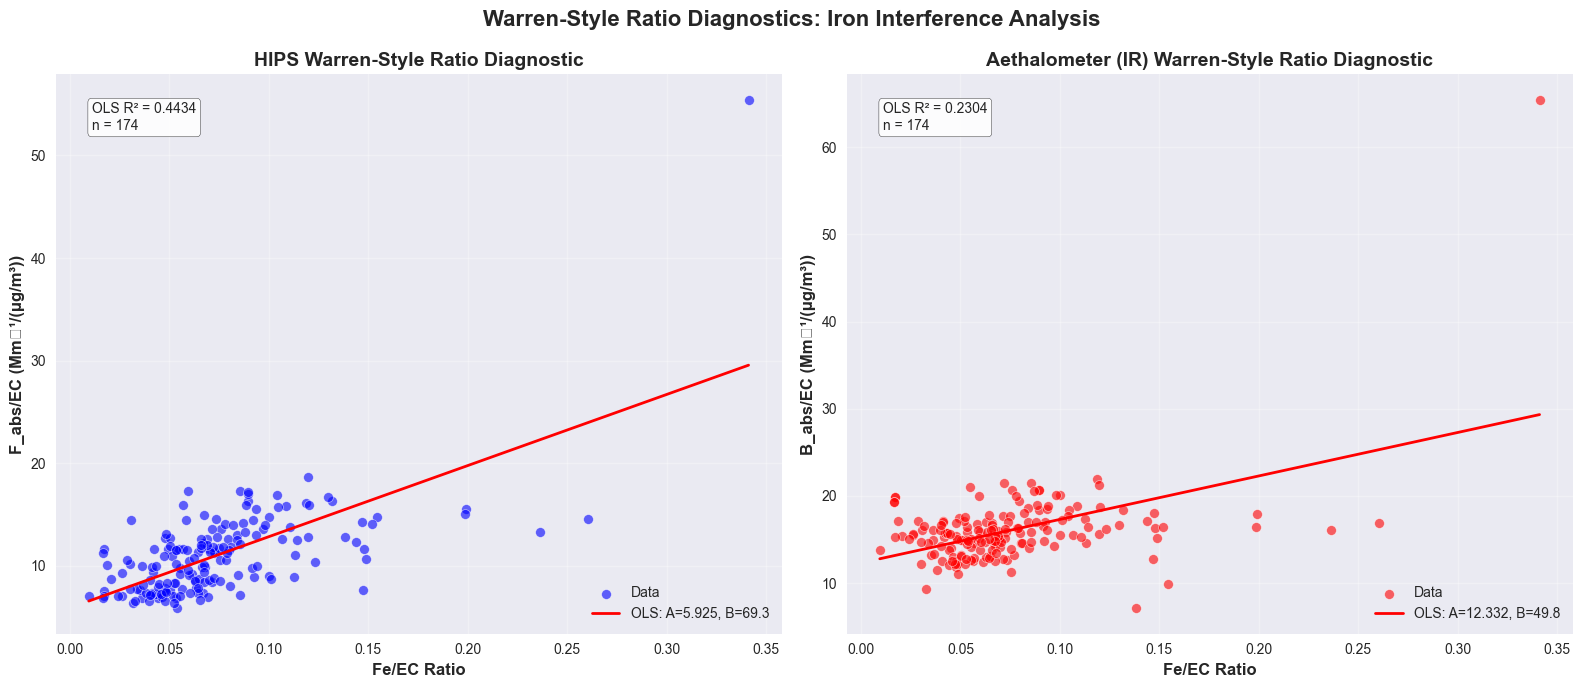

In [24]:
# Create Warren-style plots
if hips_x is not None and aeth_x is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # HIPS plot
    ax1.scatter(hips_x, hips_y, alpha=0.6, s=50, color='blue', label='Data', edgecolors='white', linewidth=0.5)
    
    # Plot regression line
    x_line = np.linspace(hips_x.min(), hips_x.max(), 100)
    ols_line = hips_results['OLS']['intercept'] + hips_results['OLS']['slope'] * x_line
    ax1.plot(x_line, ols_line, 'r-', linewidth=2, label=f"OLS: A={hips_results['OLS']['intercept']:.3f}, B={hips_results['OLS']['slope']:.1f}")
    
    ax1.set_xlabel('Fe/EC Ratio', fontsize=12, fontweight='bold')
    ax1.set_ylabel('F_abs/EC (Mm⁻¹/(μg/m³))', fontsize=12, fontweight='bold')
    ax1.set_title('HIPS Warren-Style Ratio Diagnostic', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"OLS R² = {hips_results['OLS']['r2']:.4f}\nn = {len(hips_x)}"
    ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=10)
    
    # Aethalometer plot
    ax2.scatter(aeth_x, aeth_y, alpha=0.6, s=50, color='red', label='Data', edgecolors='white', linewidth=0.5)
    
    # Plot regression line
    x_line = np.linspace(aeth_x.min(), aeth_x.max(), 100)
    ols_line = aeth_results['OLS']['intercept'] + aeth_results['OLS']['slope'] * x_line
    ax2.plot(x_line, ols_line, 'r-', linewidth=2, label=f"OLS: A={aeth_results['OLS']['intercept']:.3f}, B={aeth_results['OLS']['slope']:.1f}")
    
    ax2.set_xlabel('Fe/EC Ratio', fontsize=12, fontweight='bold')
    ax2.set_ylabel('B_abs/EC (Mm⁻¹/(μg/m³))', fontsize=12, fontweight='bold')
    ax2.set_title('Aethalometer (IR) Warren-Style Ratio Diagnostic', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"OLS R² = {aeth_results['OLS']['r2']:.4f}\nn = {len(aeth_x)}"
    ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=10)
    
    plt.suptitle('Warren-Style Ratio Diagnostics: Iron Interference Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("❌ Insufficient data for creating plots")

## 6a. Classic Cross-Plots (EC vs Absorption)

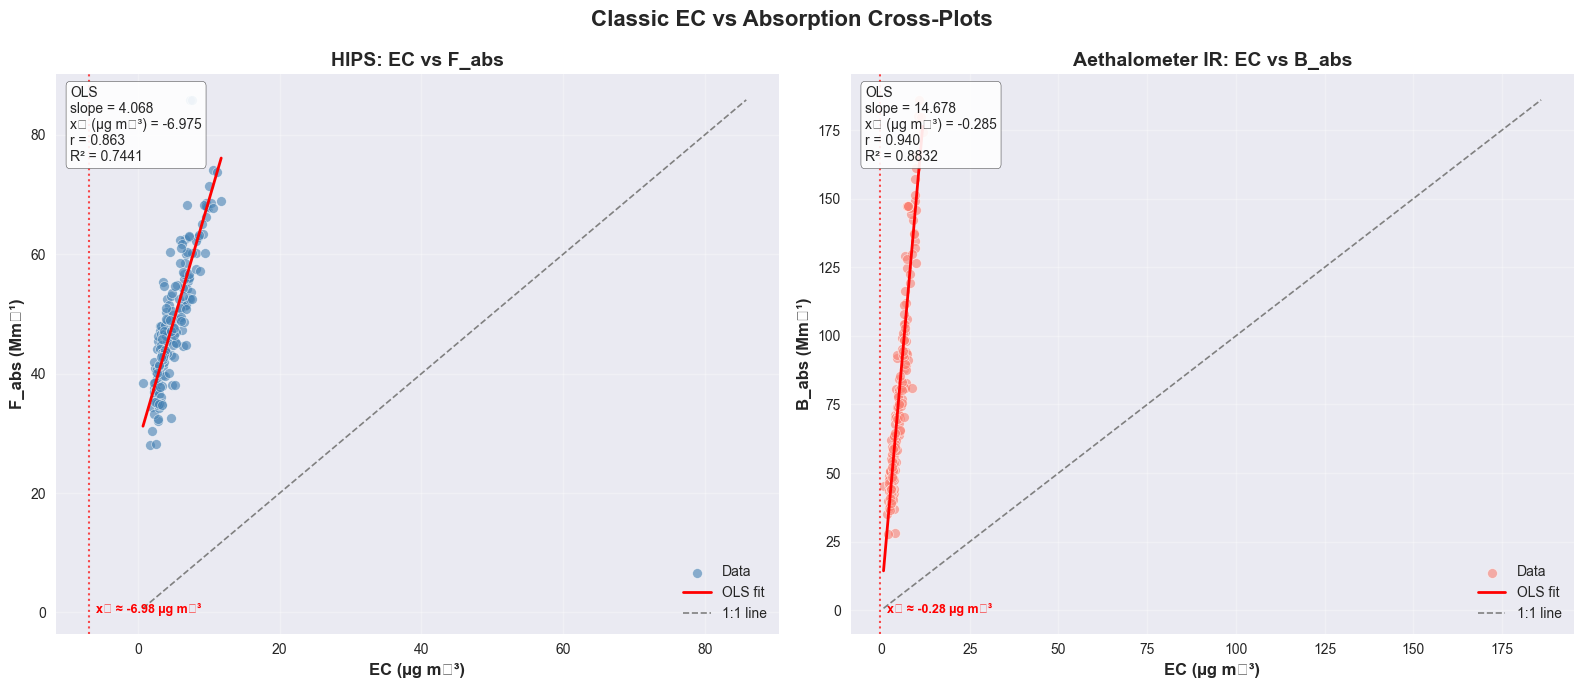


📊 Classic Cross-Plot Metrics

HIPS:
  OLS -> slope = 4.0680, x₀ = -6.975 µg m⁻³, r = 0.863, R² = 0.7441

Aethalometer_IR:
  OLS -> slope = 14.6780, x₀ = -0.285 µg m⁻³, r = 0.940, R² = 0.8832


In [30]:
# Classic EC vs absorption cross-plots with OLS fits and 1:1 reference
if 'hips_clean' in locals() and len(hips_clean) > 3 and 'aeth_clean' in locals() and len(aeth_clean) > 3:
    def regression_summary(x, y):
        x = np.asarray(x)
        y = np.asarray(y)
        ols_model = LinearRegression()
        ols_model.fit(x.reshape(-1, 1), y)
        ols_pred = ols_model.predict(x.reshape(-1, 1))
        slope = ols_model.coef_[0]
        intercept_y = ols_model.intercept_
        r2 = calculate_r_squared(x, y, ols_pred)
        r_value = stats.pearsonr(x, y)[0] if len(x) > 1 else np.nan
        x_intercept = np.nan if np.isclose(slope, 0) else -intercept_y / slope
        return {
            'slope': slope,
            'intercept_y': intercept_y,
            'x_intercept': x_intercept,
            'r': r_value,
            'r2': r2
        }
    
    hips_x_ec = hips_clean['EC_ftir'].values
    hips_y_fabs = hips_clean['HIPS_Fabs'].values
    aeth_x_ec = aeth_clean['EC_ftir'].values
    aeth_y_babs = aeth_clean['IR Babs'].values
    
    hips_classic = regression_summary(hips_x_ec, hips_y_fabs)
    aeth_classic = regression_summary(aeth_x_ec, aeth_y_babs)
    
    classic_results = {
        'HIPS': hips_classic,
        'Aethalometer_IR': aeth_classic
    }
    
    def format_line(metrics):
        xi = metrics['x_intercept']
        xi_text = f"{xi:.3f}" if np.isfinite(xi) else "NA"
        return (
            f"slope = {metrics['slope']:.3f}\n"
            f"x₀ (µg m⁻³) = {xi_text}\n"
            f"r = {metrics['r']:.3f}\n"
            f"R² = {metrics['r2']:.4f}"
        )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # HIPS plot
    ax1.scatter(hips_x_ec, hips_y_fabs, alpha=0.6, s=50, color='steelblue', edgecolors='white', linewidth=0.5, label='Data')
    x_line = np.linspace(hips_x_ec.min(), hips_x_ec.max(), 100)
    ax1.plot(x_line, hips_classic['intercept_y'] + hips_classic['slope'] * x_line,
             'r-', linewidth=2, label='OLS fit')
    diag_min = min(hips_x_ec.min(), hips_y_fabs.min())
    diag_max = max(hips_x_ec.max(), hips_y_fabs.max())
    ax1.plot([diag_min, diag_max], [diag_min, diag_max], color='gray', linestyle='--', linewidth=1.2, label='1:1 line')
    ax1.set_xlabel('EC (µg m⁻³)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('F_abs (Mm⁻¹)', fontsize=12, fontweight='bold')
    ax1.set_title('HIPS: EC vs F_abs', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.text(0.02, 0.98,
             "OLS\n" + format_line(hips_classic),
             transform=ax1.transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    xi = hips_classic['x_intercept']
    if np.isfinite(xi):
        ax1.axvline(xi, color='r', linestyle=':', linewidth=1.5, alpha=0.7)
        ax1.annotate(f"x₀ ≈ {xi:.2f} µg m⁻³", xy=(xi, ax1.get_ylim()[0]), xytext=(5, 15),
                     textcoords='offset points', color='r', fontsize=9, fontweight='bold')
    
    # Aethalometer plot
    ax2.scatter(aeth_x_ec, aeth_y_babs, alpha=0.6, s=50, color='salmon', edgecolors='white', linewidth=0.5, label='Data')
    x_line = np.linspace(aeth_x_ec.min(), aeth_x_ec.max(), 100)
    ax2.plot(x_line, aeth_classic['intercept_y'] + aeth_classic['slope'] * x_line,
             'r-', linewidth=2, label='OLS fit')
    diag_min = min(aeth_x_ec.min(), aeth_y_babs.min())
    diag_max = max(aeth_x_ec.max(), aeth_y_babs.max())
    ax2.plot([diag_min, diag_max], [diag_min, diag_max], color='gray', linestyle='--', linewidth=1.2, label='1:1 line')
    ax2.set_xlabel('EC (µg m⁻³)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('B_abs (Mm⁻¹)', fontsize=12, fontweight='bold')
    ax2.set_title('Aethalometer IR: EC vs B_abs', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.text(0.02, 0.98,
             "OLS\n" + format_line(aeth_classic),
             transform=ax2.transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    xi = aeth_classic['x_intercept']
    if np.isfinite(xi):
        ax2.axvline(xi, color='r', linestyle=':', linewidth=1.5, alpha=0.7)
        ax2.annotate(f"x₀ ≈ {xi:.2f} µg m⁻³", xy=(xi, ax2.get_ylim()[0]), xytext=(5, 15),
                     textcoords='offset points', color='r', fontsize=9, fontweight='bold')
    
    plt.suptitle('Classic EC vs Absorption Cross-Plots', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Classic Cross-Plot Metrics")
    for instrument, metrics in classic_results.items():
        xi = metrics['x_intercept']
        xi_text = f"{xi:.3f}" if np.isfinite(xi) else "NA"
        print(
            f"\n{instrument}:\n"
            f"  OLS -> slope = {metrics['slope']:.4f}, x₀ = {xi_text} µg m⁻³, "
            f"r = {metrics['r']:.3f}, R² = {metrics['r2']:.4f}"
        )
else:
    print("❌ Classic cross-plot skipped: insufficient matched data")

## 7. Summary and Comparison

In [25]:
# Create summary comparison table
if 'hips_results' in locals() and 'aeth_results' in locals():
    print("\n" + "="*80)
    print("📊 WARREN-STYLE RATIO DIAGNOSTICS SUMMARY")
    print("="*80)
    
    # Create comparison DataFrame
    summary_data = []
    
    for method in ['OLS', 'Deming']:
        summary_data.append({
            'Instrument': 'HIPS',
            'Method': method,
            'Intercept A': f"{hips_results[method]['intercept']:.3f}",
            'Slope B': f"{hips_results[method]['slope']:.1f}",
            'R²': f"{hips_results[method]['r2']:.4f}"
        })
        
        summary_data.append({
            'Instrument': 'Aethalometer (IR)',
            'Method': method,
            'Intercept A': f"{aeth_results[method]['intercept']:.3f}",
            'Slope B': f"{aeth_results[method]['slope']:.1f}",
            'R²': f"{aeth_results[method]['r2']:.4f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("📝 INTERPRETATION GUIDE:")
    print("="*80)
    
    print("\n🎯 Intercept A (Pure BC Absorption):")
    print("   - Represents absorption per unit EC when Fe/EC = 0")
    print("   - This is the 'true' MAC value for BC without iron interference")
    print(f"   - HIPS: {hips_results['OLS']['intercept']:.3f} Mm⁻¹/(μg/m³) ≈ {hips_results['OLS']['intercept']:.1f} m²/g")
    print(f"   - Aethalometer: {aeth_results['OLS']['intercept']:.3f} Mm⁻¹/(μg/m³) ≈ {aeth_results['OLS']['intercept']:.1f} m²/g")
    
    print("\n📈 Slope B (Iron-Specific Absorption):")
    print("   - Represents additional absorption contributed by iron")
    print("   - Units: Mm⁻¹/(μg/m³) per unit Fe/EC ratio")
    print(f"   - HIPS: {hips_results['OLS']['slope']:.1f} (slope magnitude)")
    print(f"   - Aethalometer: {aeth_results['OLS']['slope']:.1f} (slope magnitude)")
    
    if hips_results['OLS']['slope'] < 0:
        print("   ⚠️  Negative HIPS slope suggests iron may reduce apparent absorption")
    if aeth_results['OLS']['slope'] < 0:
        print("   ⚠️  Negative Aethalometer slope suggests iron may reduce apparent absorption")
    
    print("\n📊 R² Values:")
    print("   - Low R² values indicate weak relationship between Fe/EC and absorption ratios")
    print("   - This suggests iron interference may not be the primary driver of MAC variability")
    
    print("\n✅ SITE PARAMETERS ASSESSMENT:")
    
    # Check if parameters look reasonable
    hips_mac_reasonable = 8 < hips_results['OLS']['intercept'] < 15
    aeth_mac_reasonable = 8 < aeth_results['OLS']['intercept'] < 15
    
    if hips_mac_reasonable:
        print("   ✓ HIPS MAC value looks reasonable for BC")
    else:
        print("   ⚠️  HIPS MAC value outside typical range (8-15 m²/g)")
        
    if aeth_mac_reasonable:
        print("   ✓ Aethalometer MAC value looks reasonable for BC")
    else:
        print("   ⚠️  Aethalometer MAC value outside typical range (8-15 m²/g)")
    
    if abs(hips_results['OLS']['slope']) < 50:
        print("   ✓ Iron interference appears minimal for HIPS")
    else:
        print("   ⚠️  Significant iron interference detected for HIPS")
        
    if abs(aeth_results['OLS']['slope']) < 50:
        print("   ✓ Iron interference appears minimal for Aethalometer")
    else:
        print("   ⚠️  Significant iron interference detected for Aethalometer")
    
    print("\n" + "="*80)
    
else:
    print("❌ Analysis not completed - insufficient data")


📊 WARREN-STYLE RATIO DIAGNOSTICS SUMMARY

       Instrument Method Intercept A Slope B      R²
             HIPS    OLS       5.925    69.3  0.4434
Aethalometer (IR)    OLS      12.332    49.8  0.2304
             HIPS Deming      -0.490   156.2 -0.2550
Aethalometer (IR) Deming       0.050   216.3 -2.3405

📝 INTERPRETATION GUIDE:

🎯 Intercept A (Pure BC Absorption):
   - Represents absorption per unit EC when Fe/EC = 0
   - This is the 'true' MAC value for BC without iron interference
   - HIPS: 5.925 Mm⁻¹/(μg/m³) ≈ 5.9 m²/g
   - Aethalometer: 12.332 Mm⁻¹/(μg/m³) ≈ 12.3 m²/g

📈 Slope B (Iron-Specific Absorption):
   - Represents additional absorption contributed by iron
   - Units: Mm⁻¹/(μg/m³) per unit Fe/EC ratio
   - HIPS: 69.3 (slope magnitude)
   - Aethalometer: 49.8 (slope magnitude)

📊 R² Values:
   - Low R² values indicate weak relationship between Fe/EC and absorption ratios
   - This suggests iron interference may not be the primary driver of MAC variability

✅ SITE PARAMETE

## 8. Additional Multi-Wavelength Analysis for Aethalometer

In [26]:
# Analyze all wavelengths for Aethalometer
print("\n📊 Multi-Wavelength Aethalometer Analysis")
print("="*60)

wavelength_results = {}

for wavelength in ['UV', 'Blue', 'Green', 'Red', 'IR']:
    babs_col = f'{wavelength} Babs'
    
    if babs_col in matched_data.columns:
        # Filter for valid data
        mask = matched_data[[babs_col, 'EC_ftir', 'Iron_ChemSpec']].notna().all(axis=1)
        valid_data = matched_data[mask].copy()
        
        if len(valid_data) > 3:
            # Calculate ratios
            valid_data['Babs_EC_ratio'] = valid_data[babs_col] / valid_data['EC_ftir']
            valid_data['Fe_EC_ratio'] = (valid_data['Iron_ChemSpec'] / 1000.0) / valid_data['EC_ftir']
            
            # Remove infinites
            ratio_mask = np.isfinite(valid_data['Babs_EC_ratio']) & np.isfinite(valid_data['Fe_EC_ratio'])
            clean_data = valid_data[ratio_mask]
            
            if len(clean_data) > 3:
                x = clean_data['Fe_EC_ratio'].values
                y = clean_data['Babs_EC_ratio'].values
                
                # OLS regression
                ols_model = LinearRegression()
                ols_model.fit(x.reshape(-1, 1), y)
                
                wavelength_results[wavelength] = {
                    'intercept': ols_model.intercept_,
                    'slope': ols_model.coef_[0],
                    'r2': ols_model.score(x.reshape(-1, 1), y),
                    'n': len(x)
                }

# Display results
if wavelength_results:
    print("\n📋 Wavelength-Dependent Results (OLS):")
    print("-" * 70)
    print(f"{'Wavelength':<12} {'λ (nm)':<10} {'Intercept A':<15} {'Slope B':<12} {'R²':<8} {'n':<6}")
    print("-" * 70)
    
    wavelength_nm = {'UV': 375, 'Blue': 470, 'Green': 528, 'Red': 625, 'IR': 880}
    
    for wl in ['UV', 'Blue', 'Green', 'Red', 'IR']:
        if wl in wavelength_results:
            r = wavelength_results[wl]
            print(f"{wl:<12} {wavelength_nm[wl]:<10} {r['intercept']:<15.3f} {r['slope']:<12.1f} {r['r2']:<8.4f} {r['n']:<6}")
    
    print("\n💡 Wavelength Dependence Insights:")
    print("   - Lower wavelengths (UV, Blue) typically show higher MAC values")
    print("   - Iron absorption is also wavelength-dependent")
    print("   - Consistent negative slopes suggest complex interactions")


📊 Multi-Wavelength Aethalometer Analysis

📋 Wavelength-Dependent Results (OLS):
----------------------------------------------------------------------
Wavelength   λ (nm)     Intercept A     Slope B      R²       n     
----------------------------------------------------------------------
UV           375        18.896          976.3        0.0035   174   
Blue         470        23.994          86.6         0.2001   174   
Green        528        10.862          52.1         0.1899   174   
Red          625        17.254          65.9         0.2164   174   
IR           880        12.332          49.8         0.2304   174   

💡 Wavelength Dependence Insights:
   - Lower wavelengths (UV, Blue) typically show higher MAC values
   - Iron absorption is also wavelength-dependent
   - Consistent negative slopes suggest complex interactions


## 9. Export Results

In [27]:
# Save results to CSV for future reference
if 'hips_results' in locals() and 'aeth_results' in locals():
    # Create results DataFrame
    results_export = pd.DataFrame([
        {'Instrument': 'HIPS', 'Method': 'OLS', **hips_results['OLS']},
        {'Instrument': 'HIPS', 'Method': 'Deming', **hips_results['Deming']},
        {'Instrument': 'Aethalometer_IR', 'Method': 'OLS', **aeth_results['OLS']},
        {'Instrument': 'Aethalometer_IR', 'Method': 'Deming', **aeth_results['Deming']}
    ])
    
    # Save to CSV
    results_export.to_csv('warren_ratio_diagnostics_results.csv', index=False)
    print("\n✅ Results saved to 'warren_ratio_diagnostics_results.csv'")
    
    # Display final summary
    print("\n" + "="*80)
    print("🎯 FINAL SUMMARY")
    print("="*80)
    print(results_export.to_string(index=False))
else:
    print("❌ No results to export")


✅ Results saved to 'warren_ratio_diagnostics_results.csv'

🎯 FINAL SUMMARY
     Instrument Method  intercept      slope        r2
           HIPS    OLS   5.925197  69.268116  0.443433
           HIPS Deming  -0.490102 156.200740 -0.255003
Aethalometer_IR    OLS  12.332298  49.822320  0.230365
Aethalometer_IR Deming   0.049801 216.260358 -2.340465


In [28]:
print("\n✅ Warren-Style Ratio Diagnostics Analysis Complete!")
print("="*60)


✅ Warren-Style Ratio Diagnostics Analysis Complete!
